# Code Assignment 18 — NYC COVID-19 Daily Counts (Time-Series)

**Dataset:** [NYC DOHMH — *COVID-19 Daily Counts of Cases, Hospitalizations, and Deaths*](https://data.cityofnewyork.us/Health/COVID-19-Daily-Counts-of-Cases-Hospitalizations-an/rc75-m7u3/about_data) 
**Focus:** Build a clean **daily** time series, **visualize** with resampling (month-end, yearly), **decompose** (trend/seasonality/residual), and **test stationarity** (ADF).  
**No forecasting models** and **no ACF/PACF** yet.

---

## Instructor Guidance

 Build a clean **daily** time series from NYC COVID-19 data using **SQLite** for filtering; visualize resampled views; run **decomposition** and **ADF**.

### Pseudocode Plan 
1) **Download CSV → pandas** (parse dates) → `pd.read_csv(path, parse_dates=['date_of_interest'])`  
2) **Normalize columns to lowercase** → `df.columns = df.columns.str.lower()`  
3) **Write to SQLite** → `import sqlite3; conn = sqlite3.connect('nyc_ts.db'); df.to_sql('covid_daily', conn, if_exists='replace', index=False)`  
4) **Filter to a time window** (choose recent 12–24 months, select only needed columns)   
5) **Set DateTime index & daily frequency** → `df.set_index('date_of_interest').asfreq('D')`  
6) **Pick ONE target series** (`case_count` | `hosp_count` | `death_count`) and for now fill in missing values with zero 
7) **Resample for EDA**  
   - Month-end totals → `df[[target]].resample('M').sum()`  
   - Yearly totals → use the month-end totals to figure this code out 
8) **Decompose** (weekly seasonality) → `seasonal_decompose()`  
9) **ADF test** (raw → difference)  
   - Raw → `adfuller(s.dropna())`  
   - First difference 
10) **Short write-up**: describe trend/seasonality, ADF p-values before/after differencing, and business implications.


## Your Task

### Step 0:  Run the imports below

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8-whitegrid")
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")


### Step 1:  Read in the data and look at it

In [2]:
path = '/Users/Marcy_Student/Desktop/Marcy-Modules/marcy-git/DA2025_Lectures/Mod6/data/covid_copy.csv'
df = pd.read_csv(path, parse_dates=['date_of_interest'])
df.dtypes

date_of_interest                   datetime64[ns]
CASE_COUNT                                 object
PROBABLE_CASE_COUNT                        object
HOSPITALIZED_COUNT                         object
DEATH_COUNT                                 int64
CASE_COUNT_7DAY_AVG                        object
ALL_CASE_COUNT_7DAY_AVG                    object
HOSP_COUNT_7DAY_AVG                        object
DEATH_COUNT_7DAY_AVG                        int64
BX_CASE_COUNT                              object
BX_PROBABLE_CASE_COUNT                     object
BX_HOSPITALIZED_COUNT                       int64
BX_DEATH_COUNT                              int64
BX_CASE_COUNT_7DAY_AVG                     object
BX_PROBABLE_CASE_COUNT_7DAY_AVG            object
BX_ALL_CASE_COUNT_7DAY_AVG                 object
BX_HOSPITALIZED_COUNT_7DAY_AVG              int64
BX_DEATH_COUNT_7DAY_AVG                     int64
BK_CASE_COUNT                              object
BK_PROBABLE_CASE_COUNT                     object


### Step 2:  Keep needed columns & filter by time window 

- Chose any time window (use most recent data) that is 6 to 12 months long 


In [3]:
#converting columns to lowercase
df.columns = df.columns.str.lower()
df.columns

Index(['date_of_interest', 'case_count', 'probable_case_count',
       'hospitalized_count', 'death_count', 'case_count_7day_avg',
       'all_case_count_7day_avg', 'hosp_count_7day_avg',
       'death_count_7day_avg', 'bx_case_count', 'bx_probable_case_count',
       'bx_hospitalized_count', 'bx_death_count', 'bx_case_count_7day_avg',
       'bx_probable_case_count_7day_avg', 'bx_all_case_count_7day_avg',
       'bx_hospitalized_count_7day_avg', 'bx_death_count_7day_avg',
       'bk_case_count', 'bk_probable_case_count', 'bk_hospitalized_count',
       'bk_death_count', 'bk_case_count_7day_avg',
       'bk_probable_case_count_7day_avg', 'bk_all_case_count_7day_avg',
       'bk_hospitalized_count_7day_avg', 'bk_death_count_7day_avg',
       'mn_case_count', 'mn_probable_case_count', 'mn_hospitalized_count',
       'mn_death_count', 'mn_case_count_7day_avg',
       'mn_probable_case_count_7day_avg', 'mn_all_case_count_7day_avg',
       'mn_hospitalized_count_7day_avg', 'mn_death_count_7

In [4]:
# converting appropriate columns to int
col_list = list(df.iloc[:, 1:].columns)

for a in col_list:
    if isinstance(a, object):
       for x in col_list:
              df[x] = df[x].astype(str)
              df[x] = df[x].str.replace(',', '')
              df[x] = df[x].astype(int)

df.dtypes

date_of_interest                   datetime64[ns]
case_count                                  int64
probable_case_count                         int64
hospitalized_count                          int64
death_count                                 int64
case_count_7day_avg                         int64
all_case_count_7day_avg                     int64
hosp_count_7day_avg                         int64
death_count_7day_avg                        int64
bx_case_count                               int64
bx_probable_case_count                      int64
bx_hospitalized_count                       int64
bx_death_count                              int64
bx_case_count_7day_avg                      int64
bx_probable_case_count_7day_avg             int64
bx_all_case_count_7day_avg                  int64
bx_hospitalized_count_7day_avg              int64
bx_death_count_7day_avg                     int64
bk_case_count                               int64
bk_probable_case_count                      int64


In [5]:
# CELL 2 — Keep needed columns & filter by date in Pandas (no SQL)
df_filtered = df.iloc[:, [0,3]]
df_filtered = df_filtered[(df_filtered['date_of_interest'] >= '2023-01-01') & (df_filtered['date_of_interest'] <= '2024-12-31')]
# 2 years

In [6]:
df_filtered.isna().sum()

date_of_interest      0
hospitalized_count    0
dtype: int64

### Step 3:  Create a time series object and pick your Y (case count, hospitalized count, death count, etc)

- Use the `date_of_interest` column as your index and keep it at "Daily" frequency (try looking up set_index() in pandas)
- Fill in missing values of Y with zero 

In [7]:
#Build a daily time series, pick a target metric
# Set time index & ensure daily frequency
df_filtered = df_filtered.set_index('date_of_interest').asfreq('D')
df_filtered

,hospitalized_count
date_of_interest,
2023-01-01,218
2023-01-02,192
2023-01-03,241
2023-01-04,206
2023-01-05,232
...,...
2024-12-27,38
2024-12-28,33
2024-12-29,33


In [8]:
ts = pd.Series(df_filtered['hospitalized_count'], name='hospitalized_count')
ts.isna().sum()

np.int64(0)

### Step 4 - Visualize the Series

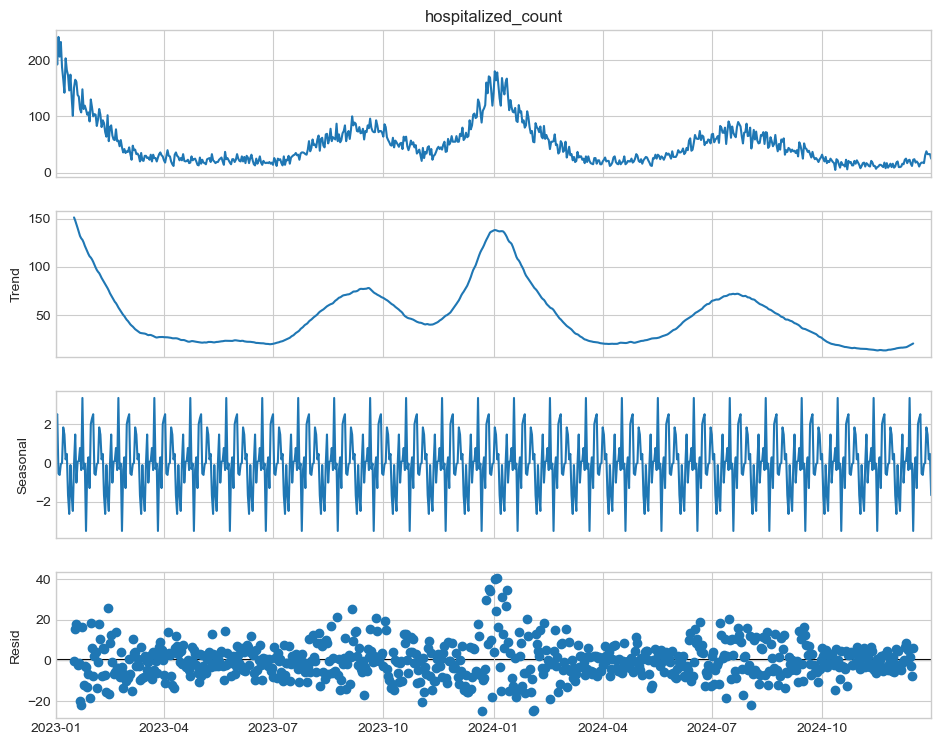

In [9]:
decomp = seasonal_decompose(ts, model='additive', period=30)
fig = decomp.plot()
fig.set_size_inches(10,8); plt.show()

### Step 5 - Resampling EDA:  Month-end and Yearly totals 

- Use the `.resample()` function to resample the series to month end and yearly 
- Visualize both resampled series 

In [10]:
# CELL 5 — Resampling EDA: Month-end and Yearly totals (Pandas-only)
m_end = ts.resample('ME').sum() # Month-end totals
y_sum = ts.resample('Y').sum()  # Yearly totals

/var/folders/gs/yv3dj4zx2tgdd5tw701ypspm0000gp/T/ipykernel_49977/1975860574.py:3: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  y_sum = ts.resample('Y').sum()  # Yearly totals


### Step 6 - Decompose the original time series object (use period = 7 since that represents weekly seasonality)
- Make a visual of the decomposition

In [11]:
display(m_end)
display(y_sum)

date_of_interest
2023-01-31    4707
2023-02-28    2057
2023-03-31     948
2023-04-30     711
2023-05-31     681
2023-06-30     642
2023-07-31     852
2023-08-31    1837
2023-09-30    2316
2023-10-31    1650
2023-11-30    1272
2023-12-31    3066
2024-01-31    3826
2024-02-29    1739
2024-03-31     792
2024-04-30     630
2024-05-31     798
2024-06-30    1492
2024-07-31    2209
2024-08-31    1776
2024-09-30    1069
2024-10-31     568
2024-11-30     391
2024-12-31     624
Freq: ME, Name: hospitalized_count, dtype: int64

date_of_interest
2023-12-31    20739
2024-12-31    15914
Freq: YE-DEC, Name: hospitalized_count, dtype: int64

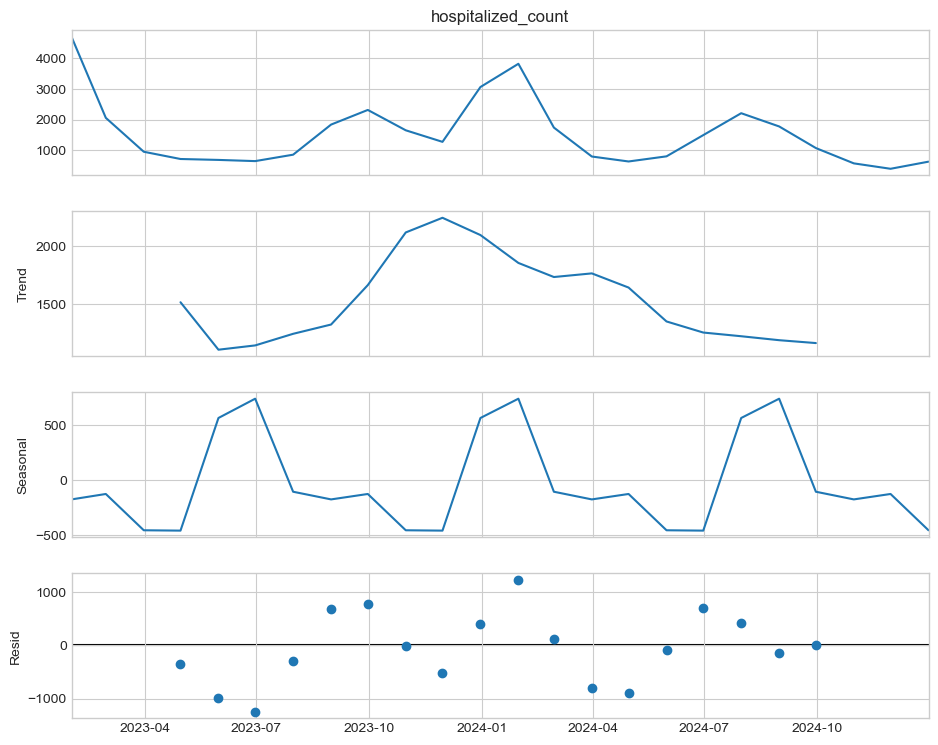

In [12]:
# CELL 6 — Decomposition (weekly seasonality → period=7)
decomp2 = seasonal_decompose(m_end, model='additive', period=7)
fig2 = decomp2.plot()
fig2.set_size_inches(10,8); plt.show()

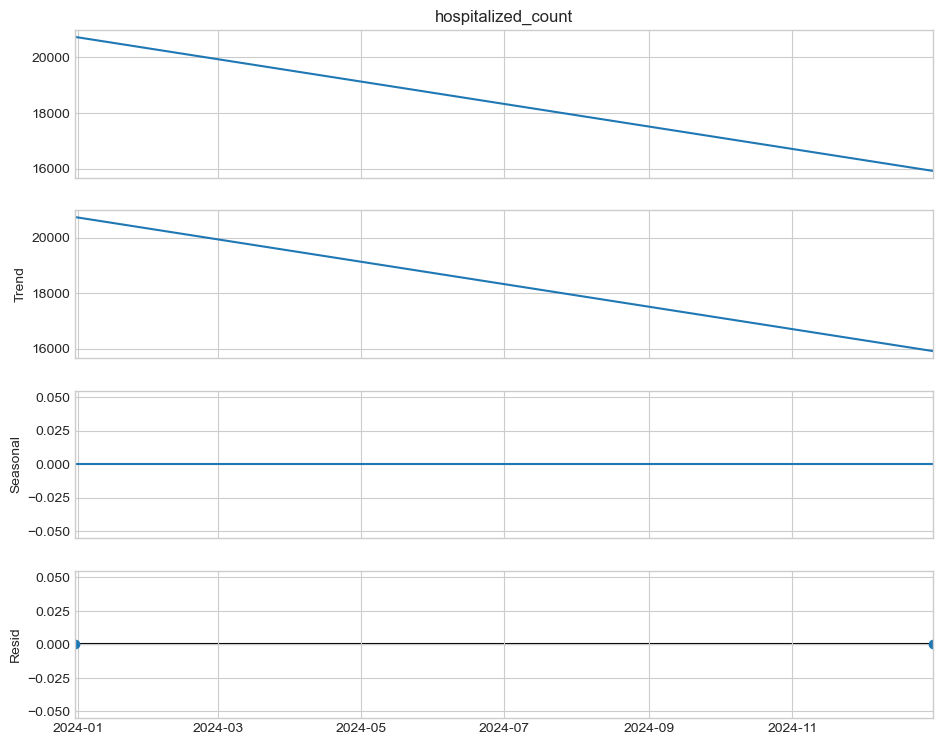

In [13]:
decomp3 = seasonal_decompose(y_sum, model='additive', period=1)
fig3 = decomp3.plot()
fig3.set_size_inches(10,8); plt.show()

### Step 7 - Do the ADF test for stationarity on the original time series and for taking a difference of 1 on the time series 
- Be sure to drop missing values (if you didn't above) 

Null Hypothesis (H₀): The data is NOT stationary (it has a "unit root").

Alternative Hypothesis (H₁): The data IS stationary.

In [23]:
# CELL 7 — ADF stationarity test: raw → difference (1) → (optional) seasonal diff(7)
print('--- ADF on Original ---')
adf_stat, pval, *_ = adfuller(ts)
print(f'ADF: {adf_stat:.2f} | p-value: {pval:.3f}')
print('\ngiven p-value, we do not need to fix stationarity')

--- ADF on Original ---
ADF: -3.30 | p-value: 0.015

given p-value, we do not need to fix stationarity


## We Share — Reflection 

1) **Narrative:** One sentence describing the series over your window (trend + weekly seasonality + volatility).  
2) **Stationarity:** Which transform (if any) produced p < 0.05? Why does that matter before modeling?  
3) **Operational lens:** Based on month-end and yearly views, what **calendar effects** would you brief stakeholders about?


### 1.
Looking at the trend, we can see higher hospitalization rates during the winter months with highly monthly volatility.

### 2.
Stationarity matters before modeling because the model is working on the assumption that our series' statistics are stable. Otherwise, forecasting will have low precision *AND* accuracy. Given our p-value for our original time-series, we can conclude that the data *IS* stationary and no fixing is needed.

### 3.
Based especially on the time range I chose, I would likely inform stakeholders that there was still a high rate of hospitalizations in the winter of 2023. However, the yearly view shows that we are seeing a decrease in hospitalizations from the start of 2023.